In [1]:
# references
# - https://ajolicoeur.wordpress.com/relativisticgan/

%pylab inline

from functools import partial

import keras
import keras_contrib

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

import glob
import imageio
import lycon
from skimage import transform
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_shape = [64, 64, 3]

img_rows = img_shape[0]
img_cols = img_shape[1]
channels = img_shape[2]
latent_dim = 100

# Following parameter and optimizer set as recommended in paper
n_critic = 5
lr = 0.0001
batch_size = 64
optimizer = keras.optimizers.Adam(lr=lr, beta_1=.5, beta_2=.999)
tnorm = keras.initializers.truncated_normal(stddev=.02)
rnorm = keras.initializers.random_normal(stddev=.02)
lrelu = lambda x: keras.activations.relu(x, alpha=.2)

In [3]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=2 / 255, preprocessing_function=lambda x: x-1)

train_data = datagen.flow_from_directory(
    target_size=img_shape[:2],
    directory = "/home/ubuntu/downloads/img_align_celeba",
    batch_size=batch_size)

Found 202599 images belonging to 1 classes.


In [4]:
start_pow = np.log2(img_rows) - 3

In [5]:
##################
#
# Build Generator
#
#################


dim = 64
k = 4
DROP = 0.00

noise = keras.Input(shape=(latent_dim, ))

noise_block = keras.layers.Dense(
    int(dim * (2**start_pow)) * 4 * 4,
    activation="relu",
    input_dim=latent_dim,
    kernel_initializer=rnorm)(noise)
noise_block = keras.layers.BatchNormalization()(noise_block)
noise_block = keras.layers.Reshape((4, 4, int(dim * (2**start_pow))))(noise_block)
noise_block = keras.layers.Dropout(DROP)(noise_block)

conv_block = noise_block

n_blocks = int(start_pow + 1)
curr_dim = int((2**(start_pow-1)) * dim)

for i in range(n_blocks):
    
    if curr_dim >= dim:
        conv_block = keras.layers.Conv2DTranspose(
            curr_dim,
            kernel_size=k,
            strides=2,
            padding="same",
            activation="relu",
            kernel_initializer=rnorm,
            use_bias=False)(conv_block)
        curr_dim = curr_dim // 2
        conv_block = keras.layers.BatchNormalization()(conv_block)
        
    else:
        conv_block = keras.layers.Conv2DTranspose(
            channels,
            kernel_size=k,
            strides=2,
            padding="same",
            activation="tanh",
            kernel_initializer=rnorm,
            use_bias=False)(conv_block)
        
    conv_block = keras.layers.Dropout(DROP)(conv_block)

img = conv_block

generator = keras.Model(noise, img)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
__________

In [6]:
import tensorflow as tf

def ln_func(x):
    return tf.contrib.layers.layer_norm(x)

layer_norm = lambda : keras.layers.Lambda(ln_func)

In [7]:
##################
#
# Build Critic
#
#################

dim = 64
k = 4
DROP = 0.05

img = keras.Input(shape=img_shape)

conv_block = img

for i in range(n_blocks):
    conv_block = keras.layers.Conv2D(
        dim*(2**i),
        kernel_size=k,
        strides=2,
        padding="same",
        activation=lrelu,
        kernel_initializer=tnorm,
    )(conv_block)
    conv_block = layer_norm()(conv_block)
#     conv_block = keras.layers.BatchNormalization()(conv_block)
    conv_block = keras.layers.Dropout(DROP)(conv_block)

conv_block = keras.layers.Conv2D(
        1,
        kernel_size=4,
        strides=1,
        padding="valid",
        kernel_initializer=tnorm,
    )(conv_block)
    
    
class_block = keras.layers.Flatten()(conv_block)


critic = keras.Model(img, class_block)

critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
lambda_1 (Lambda)            (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
lambda_2 (Lambda)            (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
__________

In [8]:
### Relativistic average Standard GAN

# No sigmoid activation in last layer of generator because BCEWithLogitsLoss() already adds it

# BCE_stable = torch.nn.BCEWithLogitsLoss()

# # Discriminator loss
# errD = ((BCE_stable(y_pred - torch.mean(y_pred_fake), y) + BCE_stable(y_pred_fake - torch.mean(y_pred), y2))/2
# errD.backward()

# # Generator loss (You may want to resample again from real and fake data)
# errG = ((BCE_stable(y_pred - torch.mean(y_pred_fake), y2) + BCE_stable(y_pred_fake - torch.mean(y_pred), y))/2
# errG.backward()

def noop_loss(target, output):
    return output

def rasg_loss(inputs):
    
    y_pred_target = inputs[0]
    y_pred_off = inputs[1]
    
    zeros_bce = K.binary_crossentropy(y_pred_target - K.mean(y_pred_off), K.ones_like(y_pred_target), 
                                      from_logits=True)
    ones_bce = K.binary_crossentropy(y_pred_off - K.mean(y_pred_target), K.zeros_like(y_pred_target), 
                                     from_logits=True)
    
    return zeros_bce + ones_bce

def rasg_loss_layer():
    
    return keras.layers.Lambda(rasg_loss)

In [9]:
#-------------------------------
#       Set up tensors for 
#       computational graph
#-------------------------------

# Image input (real sample)
real_img = keras.Input(shape=img_shape)

# Noise input
z_disc = keras.Input(shape=(latent_dim, ))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

# Discriminator determines validity of the real and fake images
y_pred_fake = critic(fake_img)
y_pred = critic(real_img)

In [10]:
#-------------------------------
# Construct Computational Graph
#       for the Critic
#-------------------------------

# Freeze generator's layers while training critic
critic.trainable = True
generator.trainable = False

critic_loss = rasg_loss_layer()([y_pred, y_pred_fake])

critic_model = keras.Model(inputs=[real_img, z_disc], outputs=[critic_loss])
critic_model.compile(loss=[noop_loss], optimizer=optimizer)

In [11]:
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------

# For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

gen_loss = rasg_loss_layer()([y_pred_fake, y_pred])

gen_model = keras.Model(inputs=[real_img, z_disc], outputs=[gen_loss])
gen_model.compile(loss=[noop_loss], optimizer=optimizer)

In [12]:
import shutil, os

n_critic = 1
n_gen = 1

def train(steps, batch_size, sample_interval=50, hist_interval=1000):
    
    d_loss_list = []
    g_loss_list = []

    shutil.rmtree("celeba_images", ignore_errors=True)
    os.makedirs("celeba_images", exist_ok=True)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    for step in tqdm(range(1,steps+1)):

        for _ in range(n_critic):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            
            imgs, _ = train_data.next()
            
            # Sample generator input
            noise = np.random.normal(0, 1, (imgs.shape[0], latent_dim))
            # Train the critic
            d_loss = critic_model.train_on_batch([imgs, noise], np.ones((imgs.shape[0], 1)))
            d_loss_list.append(d_loss)
        
        for _ in range(n_gen):
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Select a random batch of images
            imgs, _ = train_data.next()
            # Sample generator input
            noise = np.random.normal(0, 1, (imgs.shape[0], latent_dim))

            g_loss = gen_model.train_on_batch([imgs, noise], np.ones((imgs.shape[0], 1)))
            g_loss_list.append(g_loss)
        

        # If at save interval => save generated image samples
        if step % sample_interval == 0:
            print_string = f"step: {step}, D: {d_loss:g}, G: {g_loss:g}"
            print(print_string)
            sample_images(print_string, step)
            
        if step % hist_interval == 0:
            plot(range(1,step+1),d_loss_list, label="critic loss")
            plot(range(1,step+1),g_loss_list, label="generator loss")
            plt.legend()
            plt.savefig("history.png")
            plt.show()

def sample_images(print_string, step):
    # make a video with 
    # >ffmpeg -y -framerate 4 -pattern_type glob -i 'im_*.png' -pix_fmt yuv420p -vf scale=500:-1 output.mp4
    
    
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + .5

    fig, axs = plt.subplots(r, c, sharex=True, sharey=True, frameon=False, figsize=(5,5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,...], aspect="auto", interpolation="spline16")
            axs[i,j].axis('off')
            cnt += 1
    plt.tight_layout(h_pad=0, w_pad=0)
    plt.suptitle(print_string, backgroundcolor="white", fontsize=7)
    fig.savefig(f"celeba_images/im_{step:05d}.png", dpi=150)
    plt.close()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step: 100, D: -248.877, G: 178.061


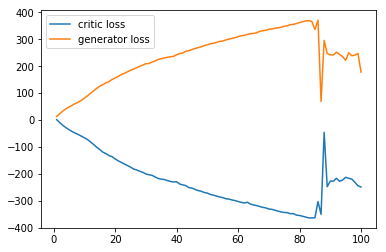

step: 200, D: -226.902, G: 289.546


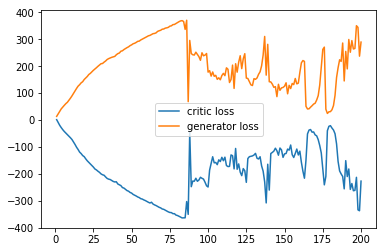

step: 300, D: -417.226, G: 44.6484


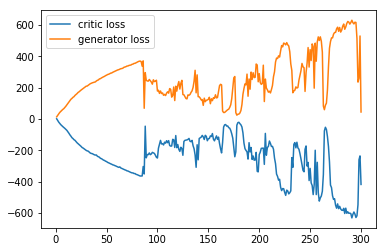

step: 400, D: -884.646, G: 919.143


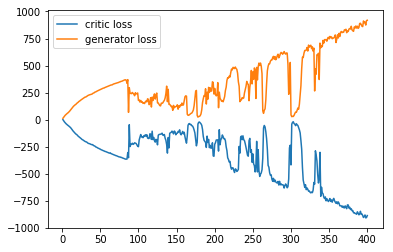

step: 500, D: -181.865, G: 268.323


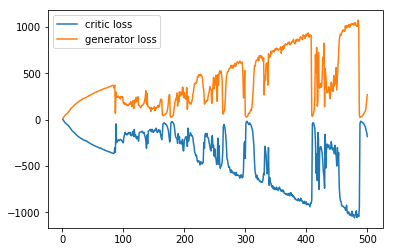

step: 600, D: -1240.55, G: 1248.66


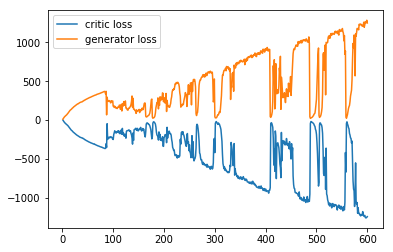

step: 700, D: -1485.6, G: 1524.32


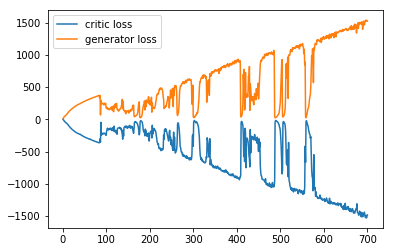

step: 800, D: -1639.98, G: 1639.16


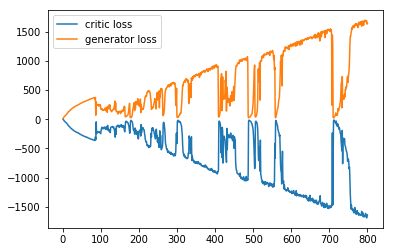

step: 900, D: -1770.65, G: 1805.55


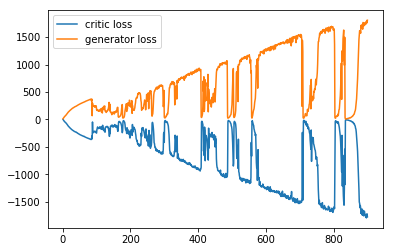

step: 1000, D: -2008.76, G: 2016.59


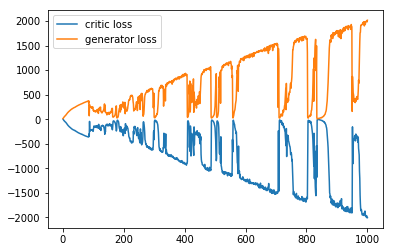

In [ ]:
train(steps=30000, batch_size=batch_size, sample_interval=100, hist_interval=100)